- Include the manual labeled data

## Setup

In [40]:
# Imports

import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm
import collections
from datasets import Dataset
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torch


In [16]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
table_path = Path("../../reports/tables")
figure_path = Path("../../reports/figures")
keywords_path = Path("../../keywords")
processed_abstracts_path = Path("../../data/processed/abstracts")
manual_ml_labels_path = Path("../../data/processed/manual_ml_labels.csv")

# Ensure directories exist
for p in [data_path, table_path, figure_path, keywords_path, processed_abstracts_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [3]:
# Constants

CREATE_ABSTRACTS_DATASET = False

#### Create Abstracts dataset (only need to do this once)

In [4]:
# Helper: Clean Abstracts
# Basic text cleaning

# Light cleaning for model input: keep most of the original signal
def clean_text_for_model(text):
    if not isinstance(text, str):
        return ""

    # Remove copyright statements at the beginning of the abstract
    text = re.sub(r"^©[^\.\n]*\.?\s*", "", text, flags=re.IGNORECASE)

    # Optionally strip URLs and extra whitespace, but keep punctuation, numbers, etc.
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [5]:
records = []

if CREATE_ABSTRACTS_DATASET:

    for folder in sorted(data_path.iterdir()):
        if not folder.is_dir():
            continue
        query_id = folder.name
        jsonl_files = list(folder.glob("*.jsonl"))
        for fp in jsonl_files:
            with fp.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    abs_txt = rec.get("abstract") or rec.get("description") or ""
                    if isinstance(abs_txt, list):
                        abs_txt = " ".join(str(x) for x in abs_txt if x)

                    # Cover date was not included in last script
                    records.append({
                        "query_id": query_id,
                        "eid": rec.get("eid"),
                        "doi": rec.get("doi"),
                        "title": rec.get("title"),
                        # "coverDate": rec.get("coverDate"),
                        "abstract": abs_txt.strip()
                    })

    df = pd.DataFrame(records)
    
    # Remove empty abstracts early
    df = df[df["abstract"].notna() & (df["abstract"].str.strip() != "")]
    df = df.reset_index(drop=True)
    
    # Clean abstracts
    df["clean_abs"] = df["abstract"].apply(clean_text_for_model)
    
    print(f"\nCollected {len(df)} abstracts from {len(df['query_id'].unique())} queries")

    # Save for later analysis
    out_path = processed_abstracts_path / "abstracts.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")


In [6]:
# Load dataframe with abstracts
# Only if it has been created earlier

if not CREATE_ABSTRACTS_DATASET:
    abstracts_path = processed_abstracts_path / "abstracts.csv"
    df = pd.read_csv(abstracts_path) 
    print(f"Loaded {len(df)} abstracts")


Loaded 52290 abstracts


In [7]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


In [8]:
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs
3373,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...
3374,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta..."


## Analyze with Keywords (Supervised / Unsupervised / Reinforcement)

Each article is classified using keyword matching based on its cleaned abstract.
The classification is **multi-label**, meaning an article may be tagged as
supervised, unsupervised, and/or reinforcement learning depending on which
keywords appear as whole words in the text.

In [9]:
# Gather all keywords 

def load_keyword_file(path: Path) -> list[str]:
    keywords = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            keywords.append(line.lower())
    return keywords


def load_all_keywords(base_dir: Path = keywords_path) -> dict[str, list[str]]:
    return {
        "supervised": load_keyword_file(base_dir / "supervised.txt"),
        "unsupervised": load_keyword_file(base_dir / "unsupervised.txt"),
        "reinforcement": load_keyword_file(base_dir / "reinforcement.txt"),
    }


ml_keywords = load_all_keywords()


In [10]:
# For each ML category, create a binary column (1/0) indicating
# whether any of that category's keywords appear in the cleaned abstract.
# (Uses word-boundary matching so e.g. 'supervised' does NOT match inside 'unsupervised')

def contains_keyword(text, keyword):
    # Escape keyword and enforce word boundaries (\b)
    pattern = rf"\b{re.escape(keyword)}\b"
    return re.search(pattern, text) is not None

for label in ml_keywords.keys():
    df[f"is_{label}"] = df["clean_abs"].apply(
        lambda t, lab=label: any(contains_keyword(str(t).lower(), w) for w in ml_keywords[lab])

    )
    
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement
3373,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,False,False,False
3374,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",False,False,False


In [11]:
# Create a column: "ml_type" that lists all categorys with True

def resolve_label(row):
    labels = []
    if row["is_supervised"]: labels.append("supervised")
    if row["is_unsupervised"]: labels.append("unsupervised")
    if row["is_reinforcement"]: labels.append("reinforcement")
    return labels or ["unknown"]

df["ml_type"] = df.apply(resolve_label, axis=1)

df.head()


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
3373,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,False,False,False,[unknown]
3374,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",False,False,False,[unknown]
3387,ml_end_of_life,2-s2.0-105009033696,10.1109/TEMSCON-ASPAC62480.2024.11025082,Clustering Locations of Collection Centers in ...,© 2024 IEEE.Waste generation is a significant ...,Waste generation is a significant issue in sus...,False,True,True,"[unsupervised, reinforcement]"
3388,ml_end_of_life,2-s2.0-85178021268,10.1188/23.CJON.595-601,"Artificial Intelligence: Basics, Impact, and H...","© 2023, Oncology Nursing Society. All rights r...",All rights reserved.Applying artificial intell...,False,False,False,[unknown]
3389,ml_end_of_life,2-s2.0-85176777527,10.1039/d3va00106g,Intersections between materials science and ma...,© 2023 RSCPlastics are an integral part of the...,"However, their widespread contamination in the...",False,False,False,[unknown]


In [12]:
# Frequency of each ML category
df["ml_type"].explode().value_counts()

ml_type
unknown          18955
supervised       10915
unsupervised      3600
reinforcement     1733
Name: count, dtype: int64

In [13]:
# Frequency for each query
df.explode("ml_type").groupby(["query_id", "ml_type"]).size().unstack(fill_value=0)

ml_type,reinforcement,supervised,unknown,unsupervised
query_id,,,,
ml_anomaly_detection_production,15,238,67,505
ml_automation,83,206,691,82
ml_defect_detection,13,273,285,100
ml_disassembly,15,92,158,24
ml_end_of_life,9,13,28,3
ml_inservice_monitoring,53,284,445,93
ml_manufacturing,342,2588,4711,748
ml_manufacturing_optimization,152,641,1249,131
ml_planning_production,168,637,878,133


In [14]:
# Percentage of abstracts that mention each ML category
df[["is_supervised", "is_unsupervised", "is_reinforcement"]].mean()

is_supervised       0.329460
is_unsupervised     0.108663
is_reinforcement    0.052309
dtype: float64

<Axes: xlabel='ml_type'>

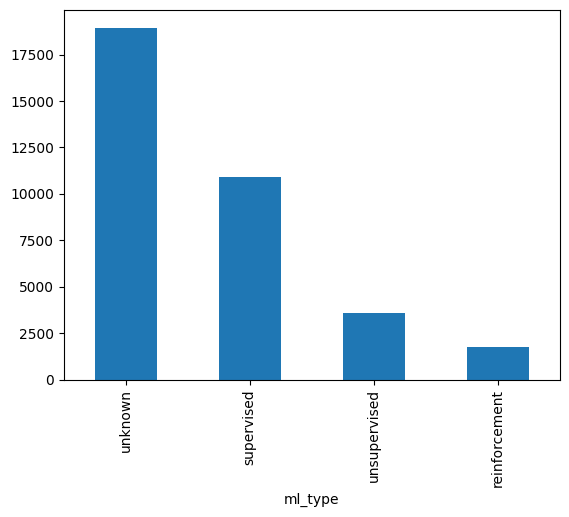

In [15]:
# Plot frequency of ML categories across all abstracts
df["ml_type"].explode().value_counts().plot(kind="bar")

In [16]:
# Sample of abstracts that were classified as "unknown"
# Should analyze to improve keyword sets
df[df["ml_type"].apply(lambda x: x == ["unknown"])].sample(2)


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
48431,ml_robotics_production,2-s2.0-85132506595,10.1109/TNSM.2022.3173436,FoReCo: A Forecast-Based Recovery Mechanism fo...,© 2004-2012 IEEE.Wireless communications repre...,Wireless communications represent a game chang...,False,False,False,[unknown]
15024,ml_manufacturing,2-s2.0-85138058430,10.1016/j.mfglet.2022.07.115,Status Quo of Smart Manufacturing Curricula of...,© 2022The manufacturing industry is in the mid...,"Together, this leads to changing requirements ...",False,False,False,[unknown]


### Notes on Keyword-Based Classification

The keyword approach provides a simple first pass, but it has clear limitations:
- Many abstracts are labeled **unknown** because keywords may be absent, implicit, or expressed differently.
- Some methods overlap terminology (e.g., “semi-supervised”), which can lead to misclassification.
- Context is ignored, so the presence of a term does not guarantee it is the main ML method.

These limitations explain the large number of “unknown” cases and motivate using a more robust model-based classifier later.

## Include manually labeled data (200 rows)

In [21]:
df_manual_ml_labels = pd.read_csv(manual_ml_labels_path, sep=";")
df_manual_ml_labels.columns = ["doi", "manual_supervised", "manual_unsupervised", "manual_rl"]

df_manual_ml_labels.head()

,doi,manual_supervised,manual_unsupervised,manual_rl
0,10.1016/j.ijpx.2020.100041,1,0,0
1,10.3390/app15126418,1,1,0
2,10.1007/s42979-025-04428-w,1,0,0
3,10.1117/12.3006709,1,0,0
4,10.1109/ICCRTEE64519.2025.11052989,1,0,0


In [22]:
df_eval = df.merge(df_manual_ml_labels, on="doi", how="inner")

# Compare keyword labels vs manual labels
comparison = {
    "supervised_accuracy": (df_eval["is_supervised"] == df_eval["manual_supervised"]).mean(),
    "unsupervised_accuracy": (df_eval["is_unsupervised"] == df_eval["manual_unsupervised"]).mean(),
    "rl_accuracy": (df_eval["is_reinforcement"] == df_eval["manual_rl"]).mean()
}

comparison


{'supervised_accuracy': 0.8131313131313131,
 'unsupervised_accuracy': 0.9292929292929293,
 'rl_accuracy': 0.8787878787878788}

In [24]:
df_manual = df_manual_ml_labels.copy()

# Ensure labels are integers (0/1)
label_cols_manual = ["manual_supervised", "manual_unsupervised", "manual_rl"]
for c in label_cols_manual:
    df_manual[c] = df_manual[c].astype(int)

# Merge manual labels into main df to get abstracts + manual labels together
df_teacher = df.merge(df_manual, on="doi", how="inner")

print("Teacher dataset size:", len(df_teacher))
df_teacher[["doi", "clean_abs"] + label_cols_manual].head()


Teacher dataset size: 198


,doi,clean_abs,manual_supervised,manual_unsupervised,manual_rl
0,10.1016/j.clwas.2025.100296,Sixteen concrete mixtures were prepared with t...,1,0,0
1,10.1007/978-3-031-21147-8_19,Circular economy (CE) business models provide ...,0,0,0
2,10.13196/j.cims.2023.0042,All rights reserved.To deal with the uncertain...,0,0,1
3,10.1007/s00170-025-15473-3,", part of Springer Nature 2025.The manufacturi...",0,1,0
4,10.1016/j.ebiom.2024.105286,"Methods: Here, we present an unsupervised Baye...",0,1,0


In [33]:
# Keep only needed columns
df_teacher_small = df_teacher[["clean_abs"] + label_cols_manual].copy()

# Simple train/val split on rows with manual labels
train_df, val_df = train_test_split(
    df_teacher_small,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))

# Optional: check label distribution in train/val
print("\nTrain label sums:")
print(train_df[label_cols_manual].sum())

print("\nVal label sums:")
print(val_df[label_cols_manual].sum())

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))

len(train_ds), len(val_ds)

Train size: 158
Val size: 40

Train label sums:
manual_supervised      79
manual_unsupervised    37
manual_rl              26
dtype: int64

Val label sums:
manual_supervised      20
manual_unsupervised    14
manual_rl               5
dtype: int64


(158, 40)

In [34]:
from transformers import AutoTokenizer

model_name_teacher = "allenai/scibert_scivocab_uncased"  # or a smaller model

tokenizer_teacher = AutoTokenizer.from_pretrained(model_name_teacher)

# Add a single multi-label 'labels' column
def add_labels_manual(example):
    example["labels"] = [
        float(example["manual_supervised"]),
        float(example["manual_unsupervised"]),
        float(example["manual_rl"]),
    ]
    return example

train_ds_l = train_ds.map(add_labels_manual)
val_ds_l   = val_ds.map(add_labels_manual)

def tokenize_batch_teacher(batch):
    return tokenizer_teacher(
        batch["clean_abs"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )

train_ds_tok = train_ds_l.map(tokenize_batch_teacher, batched=True)
val_ds_tok   = val_ds_l.map(tokenize_batch_teacher, batched=True)

def set_format(ds):
    return ds.with_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"],
    )

train_ds_tok = set_format(train_ds_tok)
val_ds_tok   = set_format(val_ds_tok)


Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [36]:
label_cols_teacher = ["manual_supervised", "manual_unsupervised", "manual_rl"]

model_teacher = AutoModelForSequenceClassification.from_pretrained(
    model_name_teacher,
    num_labels=len(label_cols_teacher),
    problem_type="multi_label_classification",
)

def compute_metrics_teacher(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))  # sigmoid
    preds = (probs >= 0.5).astype(int) # fixed threshold for evaluation

    return {
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_micro": precision_score(labels, preds, average="micro", zero_division=0),
        "recall_micro": recall_score(labels, preds, average="micro", zero_division=0),
    }

training_args_teacher = TrainingArguments(
    output_dir="./teacher_ml_type_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,   # smaller since few samples
    per_device_eval_batch_size=16,
    num_train_epochs=8,              # you can try 3–8
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    logging_steps=10,
)

trainer_teacher = Trainer(
    model=model_teacher,
    args=training_args_teacher,
    train_dataset=train_ds_tok,
    eval_dataset=val_ds_tok,
    tokenizer=tokenizer_teacher,
    compute_metrics=compute_metrics_teacher,
)

trainer_teacher.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2505832/2313217271.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_teacher = Trainer(


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision Micro,Recall Micro
1,0.594900,0.607818,0.000000,0.000000,0.000000,0.000000
2,0.573400,0.587845,0.426667,0.190476,0.444444,0.410256
3,0.584400,0.587693,0.405797,0.186667,0.466667,0.358974
4,0.507100,0.584058,0.468750,0.222222,0.600000,0.384615
5,0.493600,0.571312,0.468750,0.222222,0.600000,0.384615
6,0.412900,0.573887,0.485714,0.222222,0.548387,0.435897
7,0.380900,0.567589,0.484848,0.317460,0.592593,0.410256
8,0.369500,0.562717,0.476190,0.317460,0.625000,0.384615


TrainOutput(global_step=160, training_loss=0.491648206114769, metrics={'train_runtime': 43.7136, 'train_samples_per_second': 28.915, 'train_steps_per_second': 3.66, 'total_flos': 332575360008192.0, 'train_loss': 0.491648206114769, 'epoch': 8.0})

In [37]:
eval_results = trainer_teacher.evaluate()
eval_results


{'eval_loss': 0.5738873481750488,
 'eval_f1_micro': 0.4857142857142857,
 'eval_f1_macro': 0.2222222222222222,
 'eval_precision_micro': 0.5483870967741935,
 'eval_recall_micro': 0.4358974358974359,
 'eval_runtime': 0.3548,
 'eval_samples_per_second': 112.744,
 'eval_steps_per_second': 8.456,
 'epoch': 8.0}

In [42]:
# etter eval/prediksjon på val_ds_tok:
val_outputs = trainer_teacher.predict(val_ds_tok)
logits, labels = val_outputs.predictions, val_outputs.label_ids

probs = 1 / (1 + np.exp(-logits))
preds = (probs >= 0.5).astype(int)

import numpy as np
from sklearn.metrics import classification_report

print("Label sums in val:")
print(labels.sum(axis=0))  # hvor mange positive per label

print("\nPred sums in val (threshold 0.5):")
print(preds.sum(axis=0))   # hvor mange modellen predikerer per label

print("\nClassification report per label:")
print(classification_report(labels, preds, target_names=["sup","unsup","rl"], zero_division=0))


Label sums in val:
[20. 14.  5.]

Pred sums in val (threshold 0.5):
[31  0  0]

Classification report per label:
              precision    recall  f1-score   support

         sup       0.55      0.85      0.67        20
       unsup       0.00      0.00      0.00        14
          rl       0.00      0.00      0.00         5

   micro avg       0.55      0.44      0.49        39
   macro avg       0.18      0.28      0.22        39
weighted avg       0.28      0.44      0.34        39
 samples avg       0.42      0.36      0.38        39



In [38]:
def predict_ml_types_teacher(texts, trainer, batch_size=32, max_length=512, thresholds=None):
    # thresholds: None (no binarization), scalar, or array-like of shape (3,)
    model = trainer.model
    model.eval()

    all_probs = []
    all_preds = []

    # ensure strings
    texts = ["" if t is None else str(t) for t in texts]

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        enc = tokenizer_teacher(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        enc = {k: v.to(model.device) for k, v in enc.items()}

        with torch.no_grad():
            logits = model(**enc).logits

        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)

        if thresholds is not None:
            preds = (probs >= thresholds).astype(int)
            all_preds.append(preds)

    all_probs = np.vstack(all_probs)
    if thresholds is None:
        return all_probs, None

    all_preds = np.vstack(all_preds)
    return all_probs, all_preds


In [41]:
texts_manual = df_teacher_small["clean_abs"].tolist()
probs_manual, preds_manual = predict_ml_types_teacher(
    texts_manual,
    trainer_teacher,
    thresholds=0.5,  # or np.array([...]) per label
)

# Compare with manual labels if you like
manual_labels_array = df_teacher_small[label_cols_manual].values
print("F1 on full manual set:",
      f1_score(manual_labels_array, preds_manual, average="macro", zero_division=0))


F1 on full manual set: 0.48647717484926795


## Training a Multi-Label ML-Method Classifier Using Keyword Pseudo-Labels

- The keyword-based approach provides noisy but useful initial labels for each article (e.g., supervised / unsupervised / reinforcement).  
- In the following steps, we use these pseudo-labels to train a **multi-label transformer model** (e.g., SciBERT or DistilBERT) on the abstracts. 
- This allows the model to learn richer linguistic patterns and produce more accurate classifications than the raw keyword method, while requiring **no manual labeling up front**.


In [ ]:
label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Keep only rows that have at least one positive label
df_model = df.copy()
mask_any_label = df_model[label_cols].sum(axis=1) > 0
df_model = df_model[mask_any_label].reset_index(drop=True)

print(df_model[label_cols].mean())  # quick check of label frequencies

# Compute pos_weight for BCEWithLogitsLoss
label_array = df_model[label_cols].astype(int).values  # shape (N, num_labels)
pos_counts = label_array.sum(axis=0)                   # positives per label
neg_counts = len(df_model) - pos_counts                # negatives per label
pos_weight = neg_counts / (pos_counts + 1e-8)          # larger => more weight on positives

print("pos_weight:", pos_weight)  # quick sanity check

dataset = Dataset.from_pandas(df_model[["clean_abs"] + label_cols])

# Train/validation split
splits = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = splits["train"]
val_ds = splits["test"]


is_supervised       0.770018
is_unsupervised     0.253968
is_reinforcement    0.122257
dtype: float64
pos_weight: [0.29867155 2.9375     7.17945759]


In [19]:
# Ensure scibert directory exists
scibert_path = processed_abstracts_path / "scibert_tuned"
scibert_path.mkdir(parents=True, exist_ok=True)

# Save datasets
train_path = scibert_path / "train_ds.csv"
val_path = scibert_path / "val_ds.csv"

train_ds.to_csv(train_path, index=False)
val_ds.to_csv(val_path, index=False)

print(f"Saved train_ds to: {train_path}")
print(f"Saved val_ds to:   {val_path}")

Creating CSV from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Saved train_ds to: ../../data/processed/abstracts/scibert_tuned/train_ds.csv
Saved val_ds to:   ../../data/processed/abstracts/scibert_tuned/val_ds.csv


In [20]:
train_ds.to_pandas().head()


,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,", part of Springer Nature 2024.Additive manufa...",False,True,False
1,Predictive maintenance solutions have been rec...,True,False,False
2,Businesses and software development processes ...,False,False,True
3,Knowledge of such activity often desires frequ...,True,False,False
4,The long-sought prediction pipelines for solid...,True,False,False


In [ ]:
model_name = "allenai/scibert_scivocab_uncased"  # or "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Add a single multi-label 'labels' column
def add_labels(example):
    example["labels"] = [float(example[c]) for c in label_cols]
    return example

train_ds_l = train_ds.map(add_labels)
val_ds_l   = val_ds.map(add_labels)

def tokenize_batch(batch):
    return tokenizer(
        batch["clean_abs"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )

train_ds_tok = train_ds_l.map(tokenize_batch, batched=True)
val_ds_tok   = val_ds_l.map(tokenize_batch, batched=True)

def set_format(ds):
    return ds.with_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"],
    )

train_ds_tok = set_format(train_ds_tok)
val_ds_tok   = set_format(val_ds_tok)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
)


Map:   0%|          | 0/11340 [00:00<?, ? examples/s]

Map:   0%|          | 0/2835 [00:00<?, ? examples/s]

Map:   0%|          | 0/11340 [00:00<?, ? examples/s]

Map:   0%|          | 0/2835 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# # Compute average number of tokens per abstract using the tokenizer

# lengths = []

# for text in df["clean_abs"].tolist():
#     enc = tokenizer(
#         text,
#         truncation=True,
#         max_length=2048,
#     )
#     lengths.append(len(enc["input_ids"]))

# avg_len = sum(lengths) / len(lengths)
# max_len = max(lengths)
# min_len = min(lengths)

# print(f"Average token length: {avg_len:.2f}")
# print(f"Min tokens: {min_len}, Max tokens: {max_len}")


In [23]:
# # Count how many abstracts exceed various token-length thresholds

# thresholds = [256, 512, 768, 1024, 1500]

# lengths = []
# for text in df["clean_abs"].tolist():
#     enc = tokenizer(text, truncation=False)   # do NOT truncate → get true length
#     lengths.append(len(enc["input_ids"]))

# results = {}
# for t in thresholds:
#     results[t] = sum(l > t for l in lengths)

# print("Token length distribution:")
# for t, count in results.items():
#     print(f" > {t:4d} tokens : {count} abstracts")

# # Optional: also show % of dataset
# n = len(lengths)
# print("\nPercentages:")
# for t, count in results.items():
#     print(f" > {t:4d} tokens : {count/n*100:.2f}%")


In [24]:
# # Check cuda version etc for debugging

# print(torch.version.cuda)
# print(torch.cuda.get_device_name())
# print(torch.cuda.get_device_capability())
# print(torch.cuda.get_arch_list())

In [ ]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))           # sigmoid
    preds = (probs >= 0.5).astype(int)          # fixed 0.5 threshold for eval

    return {
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_micro": precision_score(labels, preds, average="micro", zero_division=0),
        "recall_micro": recall_score(labels, preds, average="micro", zero_division=0),
    }

class WeightedTrainer(Trainer):
    # Custom Trainer to use BCEWithLogitsLoss with pos_weight
    def __init__(self, pos_weight=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight = pos_weight

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Ensure float labels
        if labels.dtype != torch.float32:
            labels = labels.float()

        loss_fct = torch.nn.BCEWithLogitsLoss(
            pos_weight=self.pos_weight.to(logits.device)
        )
        loss = loss_fct(logits, labels)

        if return_outputs:
            return loss, outputs
        return loss

training_args = TrainingArguments(
    output_dir="./ml_type_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    logging_steps=50,
)

pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float32)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=val_ds_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    pos_weight=pos_weight_tensor,
)

trainer.train()


/tmp/ipykernel_2412288/402824578.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision Micro,Recall Micro
1,0.071100,0.057878,0.986646,0.982239,0.981674,0.991669
2,0.011300,0.025107,0.994154,0.994420,0.991408,0.996915
3,0.029200,0.021129,0.995527,0.995221,0.995373,0.995680


TrainOutput(global_step=2127, training_loss=0.08638004625858026, metrics={'train_runtime': 784.9691, 'train_samples_per_second': 43.339, 'train_steps_per_second': 2.71, 'total_flos': 8951118471106560.0, 'train_loss': 0.08638004625858026, 'epoch': 3.0})

In [24]:
# Get raw logits and labels on validation set
val_outputs = trainer.predict(val_ds_tok)
val_logits = val_outputs.predictions               # shape (N, num_labels)
val_labels = val_outputs.label_ids                 # shape (N, num_labels)
val_probs = 1 / (1 + np.exp(-val_logits))

best_thresholds = []

for j, col in enumerate(label_cols):
    y_true = val_labels[:, j]
    if y_true.sum() == 0:
        # If no positives, keep default 0.5
        best_thresholds.append(0.5)
        continue

    candidate_ts = np.linspace(0.1, 0.9, 17)      # tune between 0.1 and 0.9
    best_f1, best_t = 0.0, 0.5
    for t in candidate_ts:
        y_pred = (val_probs[:, j] >= t).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    print(col, "best_t:", best_t, "f1:", best_f1)
    best_thresholds.append(best_t)

best_thresholds = np.array(best_thresholds)
print("Per-label thresholds:", best_thresholds)


is_supervised best_t: 0.15000000000000002 f1: 0.9970272124399726
is_unsupervised best_t: 0.9 f1: 0.992816091954023
is_reinforcement best_t: 0.2 f1: 0.9972222222222222
Per-label thresholds: [0.15 0.9  0.2 ]


In [27]:
def predict_ml_types_batched(texts, trainer, thresholds=0.5, batch_size=64, max_length=512):
    all_preds = []
    all_probs = []

    model = trainer.model
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        enc = {k: v.to(model.device) for k, v in enc.items()}

        with torch.no_grad():
            logits = model(**enc).logits

        probs = torch.sigmoid(logits).cpu().numpy()

        # thresholds can be scalar or array-like of shape (num_labels,)
        preds = (probs >= thresholds).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)

    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    return all_preds, all_probs

# Ensure clean_abs has only string values
df["clean_abs"] = df["clean_abs"].fillna("")        # replace NaN/None with empty string
df["clean_abs"] = df["clean_abs"].astype(str)       # force everything to string

texts = df["clean_abs"].tolist()

# Use per-label thresholds found on validation set
preds, probs = predict_ml_types_batched(
    texts,
    trainer,
    thresholds=best_thresholds,
    batch_size=64,
    max_length=512,
)

for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]


In [28]:
for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]

pred_cols = [f"pred_{c}" for c in label_cols]
cols_to_save = [
    "query_id", "eid", "doi", "title", "abstract", "clean_abs",
] + label_cols + pred_cols

save_path = scibert_path / "abstracts_with_predictions.csv"
df[cols_to_save].to_csv(save_path, index=False)

print(f"Saved predictions to: {save_path}")

Saved predictions to: ../../data/processed/abstracts/scibert_tuned/abstracts_with_predictions.csv


## Analyze Scibert Predictions

In [29]:
pred_path = Path("../../data/processed/abstracts/scibert_tuned/abstracts_with_predictions.csv")

pred_cols = ["pred_is_supervised","pred_is_unsupervised","pred_is_reinforcement"]

In [30]:
df = pd.read_csv(pred_path)
df.head()

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,False,False,False,0,0,1
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",False,False,False,0,0,1
2,ml_end_of_life,2-s2.0-105009033696,10.1109/TEMSCON-ASPAC62480.2024.11025082,Clustering Locations of Collection Centers in ...,© 2024 IEEE.Waste generation is a significant ...,Waste generation is a significant issue in sus...,False,True,True,0,1,1
3,ml_end_of_life,2-s2.0-85178021268,10.1188/23.CJON.595-601,"Artificial Intelligence: Basics, Impact, and H...","© 2023, Oncology Nursing Society. All rights r...",All rights reserved.Applying artificial intell...,False,False,False,0,0,1
4,ml_end_of_life,2-s2.0-85176777527,10.1039/d3va00106g,Intersections between materials science and ma...,© 2023 RSCPlastics are an integral part of the...,"However, their widespread contamination in the...",False,False,False,0,0,0


In [31]:
df[pred_cols].mean()

pred_is_supervised       0.500543
pred_is_unsupervised     0.170903
pred_is_reinforcement    0.277120
dtype: float64

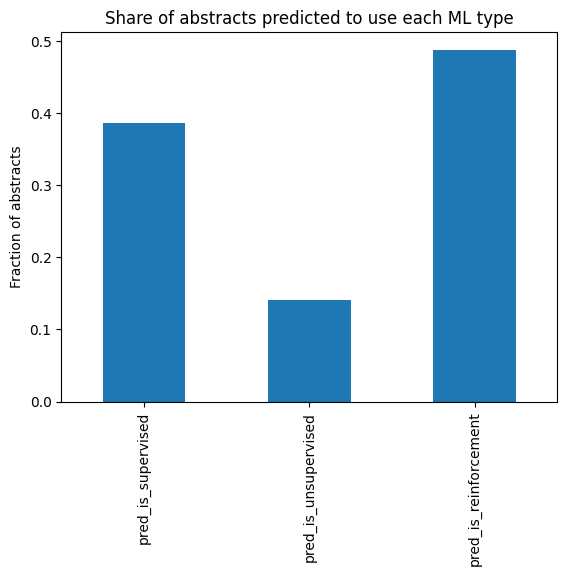

In [32]:
df[pred_cols].mean().plot(kind="bar")
plt.title("Share of abstracts predicted to use each ML type")
plt.ylabel("Fraction of abstracts")
plt.show()

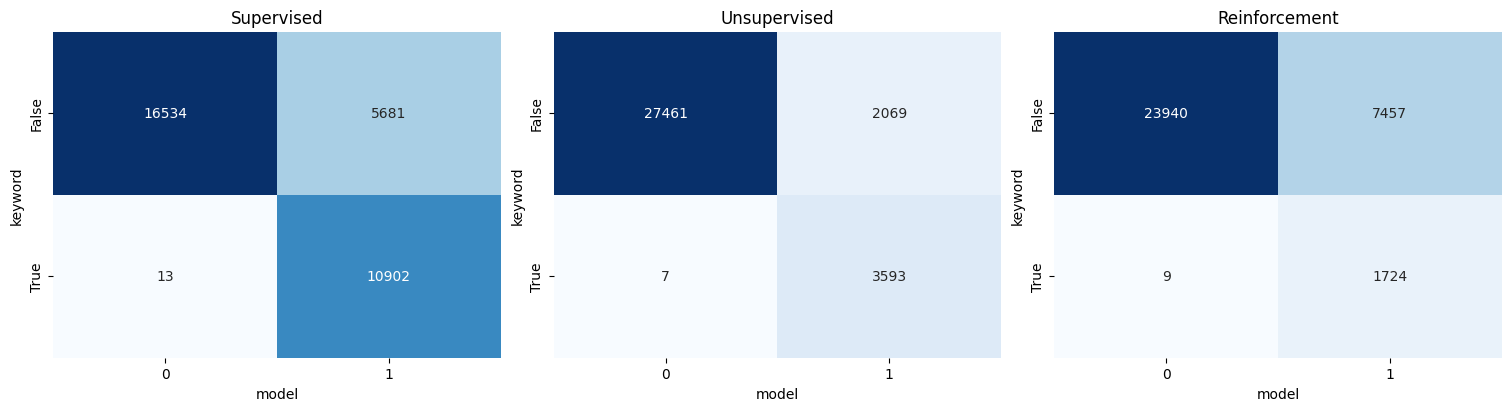

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

for ax, col in zip(axes, label_cols):
    ctab = pd.crosstab(df[col], df[f"pred_{col}"], rownames=["keyword"], colnames=["model"])
    
    sns.heatmap(
        ctab,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax
    )
    ax.set_title(col.replace("is_", "").capitalize())

plt.show()


In [34]:
# Small per-label stats
for col in label_cols:
    pred = df[f"pred_{col}"]
    true = df[col]

    tp = ((true == 1) & (pred == 1)).sum()
    fp = ((true == 0) & (pred == 1)).sum()
    fn = ((true == 1) & (pred == 0)).sum()
    tn = ((true == 0) & (pred == 0)).sum()

    print(
        f"\n=== {col} ===\n"
        f"TP: {tp}\nFP: {fp}\nFN: {fn}\nTN: {tn}\n"
        f"Precision: {tp/(tp+fp+1e-9):.3f}\n"
        f"Recall:    {tp/(tp+fn+1e-9):.3f}\n"
    )



=== is_supervised ===
TP: 10902
FP: 5681
FN: 13
TN: 16534
Precision: 0.657
Recall:    0.999


=== is_unsupervised ===
TP: 3593
FP: 2069
FN: 7
TN: 27461
Precision: 0.635
Recall:    0.998


=== is_reinforcement ===
TP: 1724
FP: 7457
FN: 9
TN: 23940
Precision: 0.188
Recall:    0.995



In [35]:
# Extract a few rows where the model disagrees with keyword labels (only among keyword-labeled rows)

mask_labeled = df[label_cols].sum(axis=1) > 0
mask_disagree = (df[[f"pred_{c}" for c in label_cols]].values != df[label_cols].values).any(axis=1)

df_mismatch = df[mask_labeled & mask_disagree]

df_mismatch.sample(10)[
    ["doi", "title", "clean_abs"] 
    + label_cols 
    + [f"pred_{c}" for c in label_cols]
]


,doi,title,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
32364,10.1007/s10853-025-10772-2,Unsupervised Graph-GAN model for stress–strain...,Out of an astronomical number of combinations ...,False,True,False,1,1,0
31264,10.1007/s10489-024-05749-8,Entity clustering-based meta-learning for link...,Fault diagnosis plays an important role in int...,False,True,False,0,1,1
645,10.1002/pro.3431,Erratum to: PixelDB: Protein-peptide complexes...,", Duran, M. and Keating, A. E. (2018) Protein ...",True,False,True,0,0,1
22412,10.1016/j.jenvman.2023.117286,Aleppo pine seeds (Pinus halepensis Mill.) as ...,Concerns about the long-term impact of non-bio...,False,False,True,1,0,1
2019,10.3390/electronics14152930,Correction: Anomaly Detection in 6G Networks U...,"In the original publication [1], the citation ...",True,False,True,0,0,1
20275,10.2118/197327-ms,Data driven smart monitoring for pipeline inte...,"However, the complexity of the asset makes it ...",True,False,True,1,0,0
6760,10.3390/rs17193365,Improving the Accuracy of Seasonal Crop Coeffi...,Highlights: What are the main findings? This r...,True,False,False,1,1,0
4483,10.11834/jig.200469,Technologies of virtual scenario construction ...,All right reserved.With the continuous improve...,False,False,True,1,0,1
14392,10.2345/1943-5967-56.2.58,Detecting Unusual Intravenous Infusion Alertin...,Objective: To detect unusual infusion alerting...,True,True,False,0,1,0
32101,10.1007/s10845-024-02562-5,DHCEN-DTC: an ensemble learning approach for s...,The capability to automatically learn from the...,True,False,True,1,0,0


In [36]:
# Compare prediction counts for rows used in training vs rows not used in training

# Identify which rows were used for training (those with at least one keyword-label = 1)
mask_train = df[label_cols].sum(axis=1) > 0
mask_not_train = ~mask_train

# Count predicted positives per class for train rows
pred_cols = [f"pred_{c}" for c in label_cols]

pred_counts_train = df[mask_train][pred_cols].sum()
pred_counts_not_train = df[mask_not_train][pred_cols].sum()

print("=== Predictions on TRAINED rows ===")
print(pred_counts_train)
print("\n=== Predictions on NON-TRAINED rows ===")
print(pred_counts_not_train)


=== Predictions on TRAINED rows ===
pred_is_supervised       10919
pred_is_unsupervised      3604
pred_is_reinforcement     1732
dtype: int64

=== Predictions on NON-TRAINED rows ===
pred_is_supervised       5664
pred_is_unsupervised     2058
pred_is_reinforcement    7449
dtype: int64


## Extract rows for manual labeling

In [ ]:
# Ensure we work on a clean copy
df_copy = df.copy()

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Define category masks
mask_supervised = df_copy["is_supervised"] == 1
mask_unsupervised = df_copy["is_unsupervised"] == 1
mask_reinforcement = df_copy["is_reinforcement"] == 1
mask_unknown = df_copy[label_cols].sum(axis=1) == 0   # no labels at all

# Function to sample up to 50 rows per category
def sample_category(mask, n=50):
    subset = df_copy[mask]
    if len(subset) == 0:
        return pd.DataFrame(columns=["doi", "clean_abs", "category"])
    return subset.sample(n=min(n, len(subset)), random_state=42)

# Sample each category
df_sup = sample_category(mask_supervised)
df_sup["category"] = "supervised"

df_unsup = sample_category(mask_unsupervised)
df_unsup["category"] = "unsupervised"

df_rl = sample_category(mask_reinforcement)
df_rl["category"] = "reinforcement"

df_unknown = sample_category(mask_unknown)
df_unknown["category"] = "unknown"

# Combine
df_sampled = pd.concat([df_sup, df_unsup, df_rl, df_unknown], ignore_index=True)

# Keep only DOI + abstract + category
df_final = df_sampled[["doi", "category", "clean_abs"]]

# Save to CSV
output_path = "manual_label_sample.csv"
df_final.to_csv(output_path, index=False)

print(f"Saved {len(df_final)} samples to {output_path}")
df_final.head()


Saved 200 samples to manual_label_sample.csv


,doi,category,clean_abs
0,10.1016/j.ijpx.2020.100041,supervised,The implementation of a marker-supported water...
1,10.3390/app15126418,supervised,Masked cold spray additive manufacturing (CSAM...
2,10.1007/s42979-025-04428-w,supervised,2025.Predictive data analytics (PDA) and Machi...
3,10.1117/12.3006709,supervised,Accompanying the microfabrication and the comp...
4,10.1109/ICCRTEE64519.2025.11052989,supervised,The agricultural sector sustains economic grow...
